In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu

In [2]:
def preprocess_fingerprint(img):
    img = cv2.equalizeHist(img)
    
    thresh_val = threshold_otsu(img)
    binary = img > thresh_val
    
    skeleton = skeletonize(binary)
    
    return binary.astype(np.uint8), skeleton.astype(np.uint8)

def extract_minutiae(skeleton):
    minutiae = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 1:
                P = [skeleton[y + dy, x + dx] for dy, dx in 
                     [(-1, 0), (-1, 1), (0, 1), (1, 1),
                      (1, 0), (1, -1), (0, -1), (-1, -1)]]
                cn = sum((P[i] != P[(i + 1) % 8]) for i in range(8)) // 2
                if cn == 1:
                    minutiae.append((x, y, 'ending'))
                elif cn == 3:
                    minutiae.append((x, y, 'bifurcation'))
    return minutiae

def match_minutiae(minutiae1, minutiae2, distance_thresh=10):
    matches = 0
    for x1, y1, t1 in minutiae1:
        for x2, y2, t2 in minutiae2:
            if t1 == t2:
                dist = np.hypot(x2 - x1, y2 - y1)
                if dist < distance_thresh:
                    matches += 1
                    break
    return matches

def compute_minutiae_match(img1_path, img2_path, visualize=True):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("Image not found.")

    binary1, skel1 = preprocess_fingerprint(img1)
    binary2, skel2 = preprocess_fingerprint(img2)

    min1 = extract_minutiae(skel1)
    min2 = extract_minutiae(skel2)

    match_count = match_minutiae(min1, min2)
    score = match_count / max(len(min1), len(min2)) * 100

    if visualize:
        height = min(img1.shape[0], img2.shape[0])
        width = min(img1.shape[1], img2.shape[1])

        orig_vis = np.hstack((
            img1[:height, :width],
            img2[:height, :width]
        ))
        plt.figure(figsize=(10, 5))
        plt.imshow(orig_vis, cmap='gray')
        plt.title('Original Fingerprint Images')
        plt.axis('off')
        plt.show()

        binary_vis = np.hstack((
            binary1[:height, :width] * 255,
            binary2[:height, :width] * 255
        ))
        plt.figure(figsize=(10, 5))
        plt.imshow(binary_vis, cmap='gray')
        plt.title('Image After : Histogram Equalization + Thresholding')
        plt.axis('off')
        plt.show()

        skel_vis = np.hstack((
            skel1[:height, :width] * 255,
            skel2[:height, :width] * 255
        ))
        plt.figure(figsize=(10, 5))
        plt.imshow(skel_vis, cmap='gray')
        plt.title('Skeleton Comparison')
        plt.axis('off')
        plt.show()

    print(f"🧬 Minutiae Match Score: {score:.2f}%")

    return score

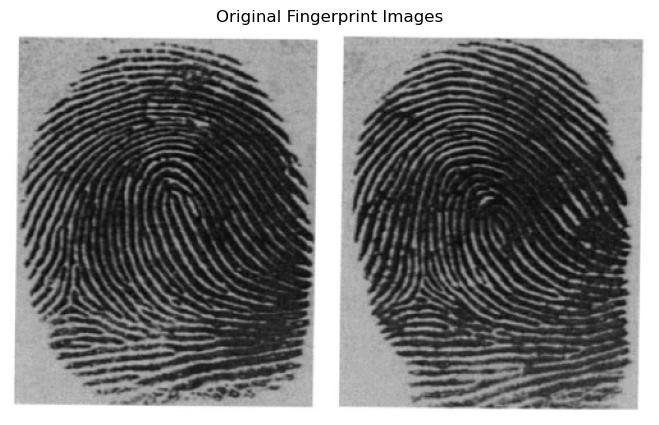

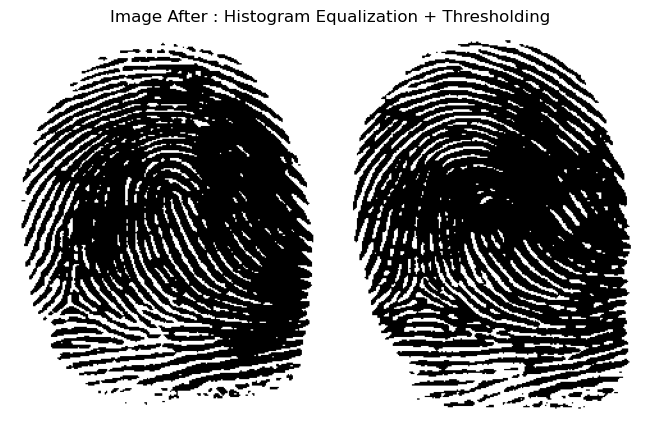

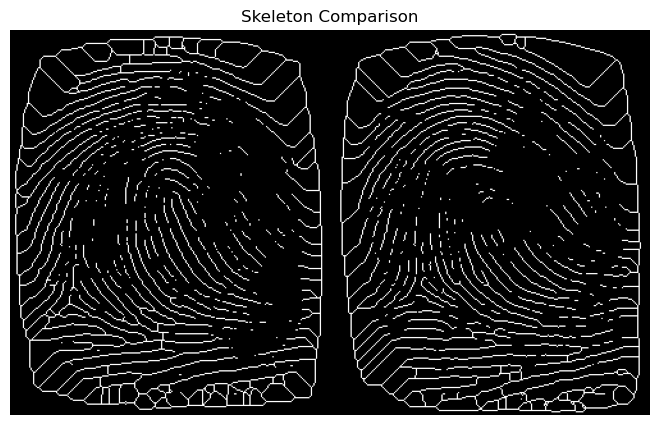

🧬 Minutiae Match Score: 81.88%


In [3]:
img_path1 = "fingerprint1.png"
img_path2 = "fingerprint2.png"

score = compute_minutiae_match(img_path1, img_path2, visualize=True)

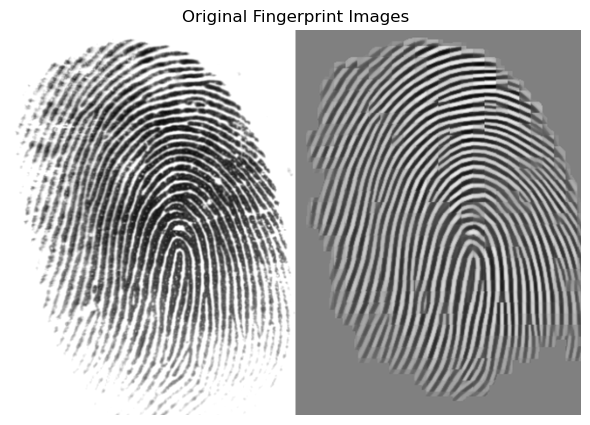

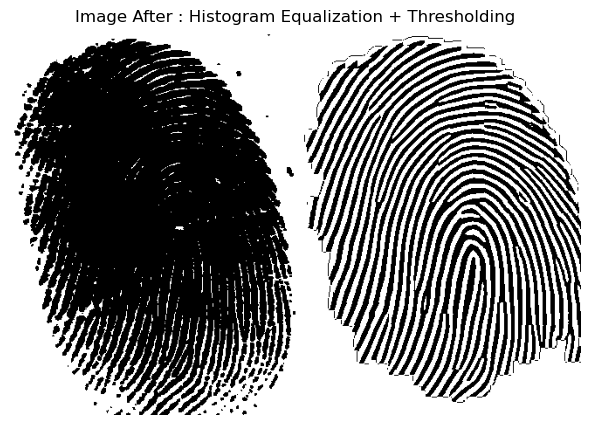

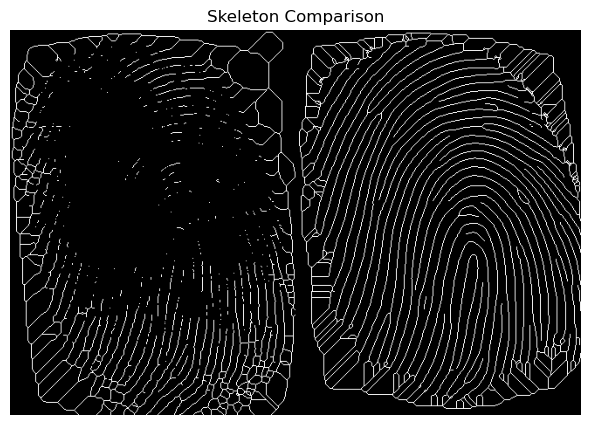

🧬 Minutiae Match Score: 31.62%


In [4]:
img_path1 = "fingerprint3.png"
img_path2 = "fingerprint4.png"

score = compute_minutiae_match(img_path1, img_path2, visualize=True)